In [1]:
get_ipython().run_line_magic('pylab', 'inline')
from astropy.io import fits
from astropy import units as u
import numpy as np
from matplotlib import pyplot as plt
from astropy.visualization import quantity_support
from scipy.interpolate import interp1d
quantity_support()  # for getting units on the axes below
from specutils import SpectralRegion
from specutils.analysis import equivalent_width 


Populating the interactive namespace from numpy and matplotlib


ModuleNotFoundError: No module named 'specutils'

In [8]:


#get this link by going to the galaxy's SDSS page and copying the link from "get FITS file"
f = fits.open("http://dr15.sdss.org/optical/spectrum/view/data/format=fits?plateid=2581&mjd=54085&fiberid=121&reduction2d=v5_7_0")  
z = 0.028893
#f = fits.open('http://dr15.sdss.org/optical/spectrum/view/data/format=fits?plateid=2241&mjd=54169&fiberid=26&reduction2d=v5_7_0')  
#z=0.02409993
#redshift = 0.025802

# The spectrum is in the second HDU of this file.
specdata = f[1].data 
f.close()

#--------------------------
h_alpha = 6563 * z + 6563
h_beta = 4861 * z + 4861
h_gamma = 4340 * z + 4340
h_delta = 4102 * z + 4102
#---------------------
#print(z)

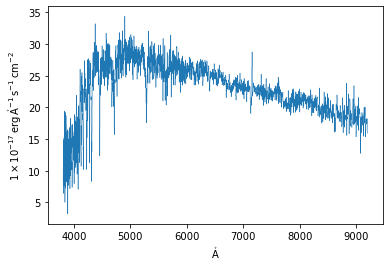

In [9]:
#turn data into AstroPy quantities & plot
from specutils import Spectrum1D
lamb = 10**specdata['loglam'] * u.AA 
flux = specdata['flux'] * u.Unit('1e-17 erg cm-2 s-1 AA-1') 
spec = Spectrum1D(spectral_axis=lamb, flux=flux) 
f, ax = plt.subplots()  
ax.step(spec.spectral_axis[::2], spec.flux[::2], linewidth = .5)
wavelengths = spec.spectral_axis.value
flux = flux.value

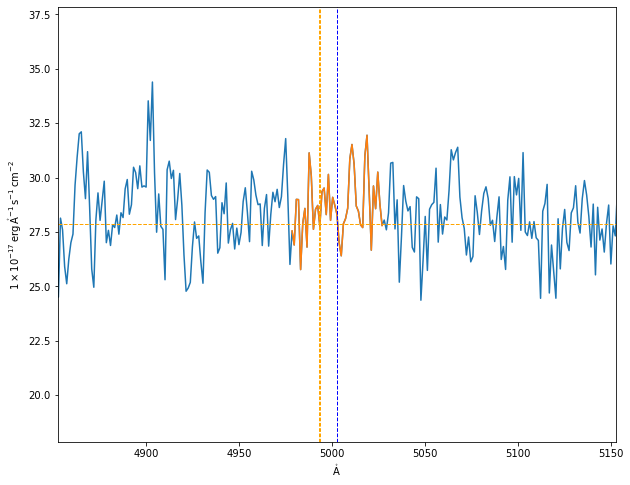

NameError: name 'equivalent_width' is not defined

In [7]:
#wave = h_alpha
wave = h_beta

percent_error = 5

up = (100 + percent_error)/100
down = (100- percent_error)/100

dip_region = (wavelengths < (wave+25)) & (wavelengths > (wave-25)) #central region where the dip occurs
dip_region_rhs = (wavelengths > (wave)) & (wavelengths < (wave+25)) #right hand side within the dip region (helpful for setting right bound)
dip_region_lhs = (wavelengths < (wave)) & (wavelengths > (wave-25)) #left hand side within the dip region

rightregion = (wavelengths < (wave+75)) & (wavelengths > (wave+25)) #region to the right-hand side of dip
leftregion= (wavelengths > (wave-75)) & (wavelengths < (wave-25)) #region to the left-hand side of dip

joined_list = [*flux[rightregion], *flux[leftregion]] #to find continuum, average values from
# the RHS and LHS regions right outside dip region. have to first combine those 2 arrays into
# one long one
continuum = np.average(joined_list) #and then average that new array!
func = interp1d(wavelengths[dip_region], flux[dip_region], kind = 'linear') #linear interpolation of dip region
# (literally connect the dots, but now I can get flux values from the lines connecting the dots)

#create interpolation of RHS so I can find the right bound
x_rhs = np.linspace(wave, wavelengths[dip_region][-1], 5000)
y_rhs = func(x_rhs)

#create interpolation of LHS so I can find the left bound
x_lhs = np.linspace(wavelengths[dip_region][0], wave, 5000)
y_lhs = func(x_lhs)

plt.figure(figsize=(10,8))
plt.plot(spec.spectral_axis, spec.flux)

continuum_new = continuum -0.5 #if you think the suggested one is wrong, add/subtract a bit!

tolerance = 0.05 #how close does the continuum need to be to the interpolation?


#can make this small for gradual spikes, big for very sharp spikes
leftbound = x_lhs[(np.abs(y_lhs - continuum_new) < tolerance)][-1] # the [-1] at the end means to 
# take the last array element of this, which would be the most central one (ie the one we want)
# instead of a value on the left or something
rightbound = x_rhs[(np.abs(y_rhs - continuum_new) < tolerance)][0] 

leftbound_new = leftbound +0
rightbound_new = rightbound -10

plt.ylim(continuum_new - 10, continuum_new + 10)
plt.xlim(wave-150, wave+150)

plt.plot(wavelengths[dip_region], func(wavelengths[dip_region]))
plt.axvline(rightbound_new, color="orange", linestyle="--", linewidth = "1")
plt.axvline(leftbound_new, color="orange", linestyle="--", linewidth = "1")
plt.axhline(y=continuum_new, color="orange", linestyle="--", linewidth = "1")
plt.axvline(wave, color="blue", linestyle="--", linewidth = "1") #approximate wavelength of line

li = np.where((spec.spectral_axis>leftbound_new*u.AA) & (spec.spectral_axis<rightbound_new*u.AA))
plt.fill_between(spec.spectral_axis[li], y1=continuum_new, y2=spec.flux[li], alpha = .2)
plt.show()


print("EW with continuum in use: {:.3f}".format(equivalent_width(spec, regions=SpectralRegion(leftbound_new*u.AA, rightbound_new*u.AA), continuum=continuum_new* u.Unit('1e-17 erg cm-2 s-1 AA-1'))))
print("redshift: {:.6f}".format(z))

# print("suggested continuum: {:.3f} A ".format(continuum))
# print("continuum in use: {:.3f} A ".format(continuum_new))
# print("Top error continum: {:.3f} A ".format(continuum*up))
# print("Top error: {:.3f}".format(equivalent_width(spec, regions=SpectralRegion(leftbound_new*u.AA, rightbound_new*u.AA), continuum=(continuum_new * up)* u.Unit('1e-17 erg cm-2 s-1 AA-1'))))
# print("Lower error continum {:.3f} A ".format(continuum*down))
# print("Bottom Error: {:.3f}".format(equivalent_width(spec, regions=SpectralRegion(leftbound_new*u.AA, rightbound_new*u.AA), continuum=(continuum_new * down)* u.Unit('1e-17 erg cm-2 s-1 AA-1'))))


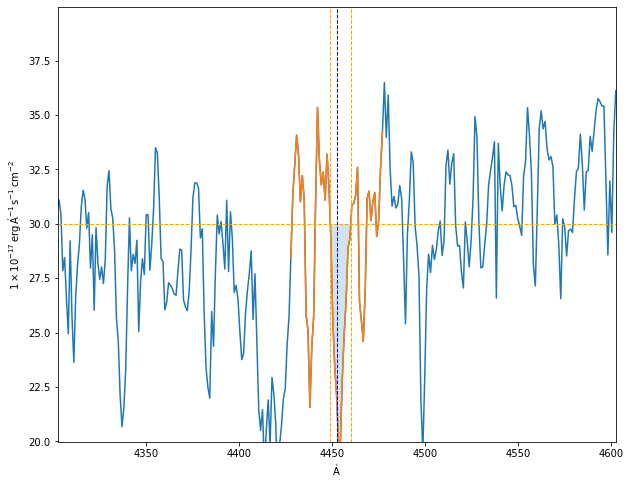

EW with continuum in use: 1.922 Angstrom
redshift: 0.025918


In [5]:
#wave = h_alpha
#wave = h_beta
wave = h_gamma
#wave = h_delta

percent_error = 5

up = (100 + percent_error)/100
down = (100- percent_error)/100

dip_region = (wavelengths < (wave+25)) & (wavelengths > (wave-25)) #central region where the dip occurs
dip_region_rhs = (wavelengths > (wave)) & (wavelengths < (wave+25)) #right hand side within the dip region (helpful for setting right bound)
dip_region_lhs = (wavelengths < (wave)) & (wavelengths > (wave-25)) #left hand side within the dip region

rightregion = (wavelengths < (wave+75)) & (wavelengths > (wave+25)) #region to the right-hand side of dip
leftregion= (wavelengths > (wave-75)) & (wavelengths < (wave-25)) #region to the left-hand side of dip

joined_list = [*flux[rightregion], *flux[leftregion]] #to find continuum, average values from
# the RHS and LHS regions right outside dip region. have to first combine those 2 arrays into
# one long one
continuum = np.average(joined_list) #and then average that new array!
func = interp1d(wavelengths[dip_region], flux[dip_region], kind = 'linear') #linear interpolation of dip region
# (literally connect the dots, but now I can get flux values from the lines connecting the dots)

#create interpolation of RHS so I can find the right bound
x_rhs = np.linspace(wave, wavelengths[dip_region][-1], 5000)
y_rhs = func(x_rhs)

#create interpolation of LHS so I can find the left bound
x_lhs = np.linspace(wavelengths[dip_region][0], wave, 5000)
y_lhs = func(x_lhs)

plt.figure(figsize=(10,8))
plt.plot(spec.spectral_axis, spec.flux)

continuum_new = continuum +2.5#if you think the suggested one is wrong, add/subtract a bit!

tolerance = 0.05 #how close does the continuum need to be to the interpolation?


#can make this small for gradual spikes, big for very sharp spikes
leftbound = x_lhs[(np.abs(y_lhs - continuum_new) < tolerance)][-1] # the [-1] at the end means to 
# take the last array element of this, which would be the most central one (ie the one we want)
# instead of a value on the left or something
rightbound = x_rhs[(np.abs(y_rhs - continuum_new) < tolerance)][0] 

leftbound_new = leftbound +0
rightbound_new = rightbound -0

plt.ylim(continuum_new - 10, continuum_new + 10)
plt.xlim(wave-150, wave+150)

plt.plot(wavelengths[dip_region], func(wavelengths[dip_region]))
plt.axvline(rightbound_new, color="orange", linestyle="--", linewidth = "1")
plt.axvline(leftbound_new, color="orange", linestyle="--", linewidth = "1")
plt.axhline(y=continuum_new, color="orange", linestyle="--", linewidth = "1")
plt.axvline(wave, color="blue", linestyle="--", linewidth = "1") #approximate wavelength of line

li = np.where((spec.spectral_axis>leftbound_new*u.AA) & (spec.spectral_axis<rightbound_new*u.AA))
plt.fill_between(spec.spectral_axis[li], y1=continuum_new, y2=spec.flux[li], alpha = .2)
plt.show()


print("EW with continuum in use: {:.3f}".format(equivalent_width(spec, regions=SpectralRegion(leftbound_new*u.AA, rightbound_new*u.AA), continuum=continuum_new* u.Unit('1e-17 erg cm-2 s-1 AA-1'))))
print("redshift: {:.6f}".format(z))

# print("suggested continuum: {:.3f} A ".format(continuum))
# print("continuum in use: {:.3f} A ".format(continuum_new))
# print("Top error continum: {:.3f} A ".format(continuum*up))
# print("Top error: {:.3f}".format(equivalent_width(spec, regions=SpectralRegion(leftbound_new*u.AA, rightbound_new*u.AA), continuum=(continuum_new * up)* u.Unit('1e-17 erg cm-2 s-1 AA-1'))))
# print("Lower error continum {:.3f} A ".format(continuum*down))
# print("Bottom Error: {:.3f}".format(equivalent_width(spec, regions=SpectralRegion(leftbound_new*u.AA, rightbound_new*u.AA), continuum=(continuum_new * down)* u.Unit('1e-17 erg cm-2 s-1 AA-1'))))


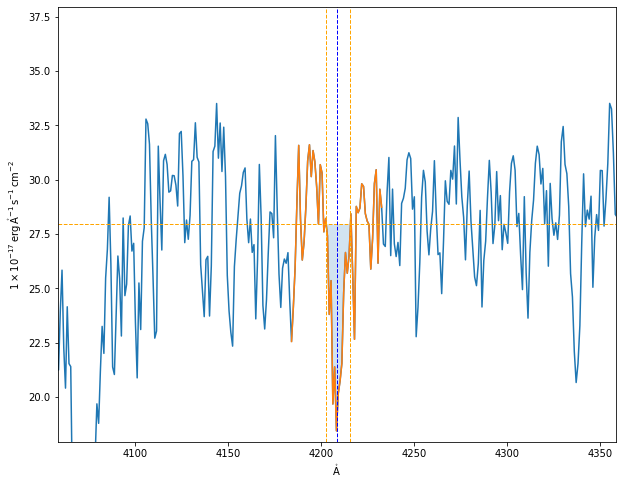

EW with continuum in use: 2.099 Angstrom
redshift: 0.025918


In [6]:
#wave = h_alpha
#wave = h_beta
#wave = h_gamma
wave = h_delta

percent_error = 5

up = (100 + percent_error)/100
down = (100- percent_error)/100

dip_region = (wavelengths < (wave+25)) & (wavelengths > (wave-25)) #central region where the dip occurs
dip_region_rhs = (wavelengths > (wave)) & (wavelengths < (wave+25)) #right hand side within the dip region (helpful for setting right bound)
dip_region_lhs = (wavelengths < (wave)) & (wavelengths > (wave-25)) #left hand side within the dip region

rightregion = (wavelengths < (wave+75)) & (wavelengths > (wave+25)) #region to the right-hand side of dip
leftregion= (wavelengths > (wave-75)) & (wavelengths < (wave-25)) #region to the left-hand side of dip

joined_list = [*flux[rightregion], *flux[leftregion]] #to find continuum, average values from
# the RHS and LHS regions right outside dip region. have to first combine those 2 arrays into
# one long one
continuum = np.average(joined_list) #and then average that new array!
func = interp1d(wavelengths[dip_region], flux[dip_region], kind = 'linear') #linear interpolation of dip region
# (literally connect the dots, but now I can get flux values from the lines connecting the dots)

#create interpolation of RHS so I can find the right bound
x_rhs = np.linspace(wave, wavelengths[dip_region][-1], 5000)
y_rhs = func(x_rhs)

#create interpolation of LHS so I can find the left bound
x_lhs = np.linspace(wavelengths[dip_region][0], wave, 5000)
y_lhs = func(x_lhs)

plt.figure(figsize=(10,8))
plt.plot(spec.spectral_axis, spec.flux)

continuum_new = continuum +0 #if you think the suggested one is wrong, add/subtract a bit!

tolerance = 0.05 #how close does the continuum need to be to the interpolation?


#can make this small for gradual spikes, big for very sharp spikes
leftbound = x_lhs[(np.abs(y_lhs - continuum_new) < tolerance)][-1] # the [-1] at the end means to 
# take the last array element of this, which would be the most central one (ie the one we want)
# instead of a value on the left or something
rightbound = x_rhs[(np.abs(y_rhs - continuum_new) < tolerance)][0] 

leftbound_new = leftbound +0
rightbound_new = rightbound -0

plt.ylim(continuum_new - 10, continuum_new + 10)
plt.xlim(wave-150, wave+150)

plt.plot(wavelengths[dip_region], func(wavelengths[dip_region]))
plt.axvline(rightbound_new, color="orange", linestyle="--", linewidth = "1")
plt.axvline(leftbound_new, color="orange", linestyle="--", linewidth = "1")
plt.axhline(y=continuum_new, color="orange", linestyle="--", linewidth = "1")
plt.axvline(wave, color="blue", linestyle="--", linewidth = "1") #approximate wavelength of line

li = np.where((spec.spectral_axis>leftbound_new*u.AA) & (spec.spectral_axis<rightbound_new*u.AA))
plt.fill_between(spec.spectral_axis[li], y1=continuum_new, y2=spec.flux[li], alpha = .2)
plt.show()


print("EW with continuum in use: {:.3f}".format(equivalent_width(spec, regions=SpectralRegion(leftbound_new*u.AA, rightbound_new*u.AA), continuum=continuum_new* u.Unit('1e-17 erg cm-2 s-1 AA-1'))))
print("redshift: {:.6f}".format(z))

# print("suggested continuum: {:.3f} A ".format(continuum))
# print("continuum in use: {:.3f} A ".format(continuum_new))
# print("Top error continum: {:.3f} A ".format(continuum*up))
# print("Top error: {:.3f}".format(equivalent_width(spec, regions=SpectralRegion(leftbound_new*u.AA, rightbound_new*u.AA), continuum=(continuum_new * up)* u.Unit('1e-17 erg cm-2 s-1 AA-1'))))
# print("Lower error continum {:.3f} A ".format(continuum*down))
# print("Bottom Error: {:.3f}".format(equivalent_width(spec, regions=SpectralRegion(leftbound_new*u.AA, rightbound_new*u.AA), continuum=(continuum_new * down)* u.Unit('1e-17 erg cm-2 s-1 AA-1'))))
